<a href="https://colab.research.google.com/github/Alexy71/IA2/blob/main/3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
!ls
%mkdir data
!ls
import sys

sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks/SIS421/Examenes/2doParcial/3/data')
sys.path.insert(1, '/content/gdrive/MyDrive/Colab Notebooks/SIS421/Examenes/2doParcial/3')


data  gdrive  sample_data
mkdir: cannot create directory ‘data’: File exists
data  gdrive  sample_data


In [13]:
import shutil

shutil.copy("/content/gdrive/MyDrive/Colab Notebooks/sis421/Examenes/2doParcial/Cloth.zip","/content/data/cloth.zip")

'/content/data/cloth.zip'

In [14]:
import zipfile
with zipfile.ZipFile('./data/cloth.zip', 'r') as zip_ref:
    zip_ref.extractall('./cloth')

In [15]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [16]:
DATA_DIR = './cloth'

dataset = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
dataset = dataset[['image_path', 'label_type', 'label_path']]
dataset['image_path'] = dataset['image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
dataset['label_path'] = dataset['label_path'].apply(lambda lbl_pth: os.path.join(DATA_DIR, 'labels', lbl_pth))

# seleccionar un subconjunto de datos con anotaciones a nivel de píxel
dataset = dataset[dataset['label_type']=='pixel-level']

# datos aleatorios
dataset = dataset.sample(frac=1).reset_index(drop=True)

# se divide 90/10 para el train/val
valid_df = dataset.sample(frac=0.05, random_state=42)
train_df = dataset.drop(valid_df.index)
len(train_df), len(valid_df)

(954, 50)

In [17]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Obtener nombre de clases
class_names = class_dict['class_name'].tolist()
# Reescritura de la clase 'nula' para evitar un valor NaN
class_names[0] = 'null'
# Obtener el rgb de las clases
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('Todas las clases de conjuntos de datos y sus valores RGB correspondientes en las etiquetas:')
print('\nNombre de las clases: ', class_names)
print('\nValor de RGB de las clases: ', class_rgb_values)

Todas las clases de conjuntos de datos y sus valores RGB correspondientes en las etiquetas:

Nombre de las clases:  ['null', 'accessories', 'bag', 'belt', 'blazer', 'blouse', 'bodysuit', 'boots', 'bra', 'bracelet', 'cape', 'cardigan', 'clogs', 'coat', 'dress', 'earrings', 'flats', 'glasses', 'gloves', 'hair', 'hat', 'heels', 'hoodie', 'intimate', 'jacket', 'jeans', 'jumper', 'leggings', 'loafers', 'necklace', 'panties', 'pants', 'pumps', 'purse', 'ring', 'romper', 'sandals', 'scarf', 'shirt', 'shoes', 'shorts', 'skin', 'skirt', 'sneakers', 'socks', 'stockings', 'suit', 'sunglasses', 'sweater', 'sweatshirt', 'swimwear', 't-shirt', 'tie', 'tights', 'top', 'vest', 'wallet', 'watch', 'wedges']

Valor de RGB de las clases:  [[69, 6, 90], [70, 12, 95], [71, 18, 101], [72, 25, 107], [72, 30, 112], [72, 35, 116], [71, 40, 120], [70, 47, 124], [69, 52, 127], [68, 57, 130], [66, 61, 132], [64, 67, 135], [62, 72, 136], [61, 76, 137], [58, 82, 139], [56, 86, 139], [54, 90, 140], [52, 94, 141], [50

In [18]:
# Útil para preseleccionar clases específicas en conjuntos de datos con una gran cantidad de clases

select_classes = ['null', 'accessories', 'bag', 'belt', 'blazer', 'blouse', 'bodysuit',
                  'boots', 'bra', 'bracelet', 'cape', 'cardigan', 'clogs', 'coat', 'dress',
                  'earrings', 'flats', 'glasses', 'gloves', 'hair', 'hat', 'heels', 'hoodie',
                  'intimate', 'jacket', 'jeans', 'jumper', 'leggings', 'loafers', 'necklace',
                  'panties', 'pants', 'pumps', 'purse', 'ring', 'romper', 'sandals', 'scarf',
                  'shirt', 'shoes', 'shorts', 'skin', 'skirt', 'sneakers', 'socks', 'stockings',
                  'suit', 'sunglasses', 'sweater', 'sweatshirt', 'swimwear', 't-shirt', 'tie',
                  'tights', 'top', 'vest', 'wallet', 'watch', 'wedges']

# Obtenga valores RGB de las clases requeridas
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

In [19]:
# función auxiliar para la visualización de datos
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Realice una codificación en caliente en la etiqueta
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Realice una codificación en caliente inversa en labels / preds
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

# Realice la codificación de colores en las salidas inversas uno-caliente
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [20]:
class ClothesDataset(torch.utils.data.Dataset):
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['image_path'].tolist()
        self.mask_paths = df['label_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # leer image y masks
        image = cv2.imread(self.image_paths[i])[:,:,::-1]
        mask = cv2.imread(self.mask_paths[i])[:,:,::-1]
        
        # una máscara de codificación en caliente
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # aplicar aumento
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # aplicar procesamiento
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.image_paths)

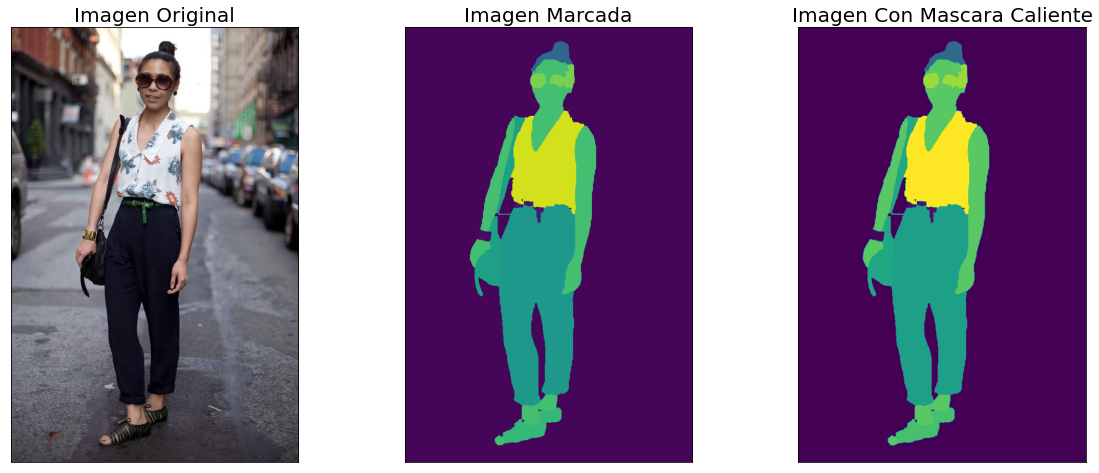

In [21]:
dataset = ClothesDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    Imagen_Original = image,
    imagen_marcada = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    imagen_con_mascara_caliente = reverse_one_hot(mask)
)